In [1]:
import sys
import os
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from functools import reduce

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from SCOU_NC_LoQ_NUTS import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def visualize_and_export(input_file, obs, lod, loq, molecule):

    output_file = input_file.copy()
    
    # preprocessing in log10 scale:
    for column in ['muX', 'ICL', 'ICU', obs, lod, loq]:
        output_file[column] = np.log10(np.exp(output_file[column]))

    
    output_file = output_file.rename(columns={obs:'obs',
                                            lod:'lod',
                                            loq:'loq'})

    # visualization:
    with plt.style.context(['science', 'notebook', 'grid']):
    
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(output_file.dateStart.values, output_file.muX.values, label='Smoothed signal', color='green', linewidth=8, zorder=3)
        
        ax_dict['A'].plot(output_file.dateStart.values, output_file.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
        ax_dict['A'].plot(output_file.dateStart.values, output_file.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
        
        ax_dict['A'].fill_between(output_file.dateStart.values, output_file.ICL.values, output_file.ICU.values, alpha=.3, color='green')
    
        
        scatter_points = ax_dict['A'].scatter(output_file.dateStart.values, output_file.obs.values, label='Measurements', 
                             c=output_file.pout.values,
                             cmap='bwr', edgecolor='black', s=360, zorder=3,
                             linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
        lod_points = ax_dict['A'].scatter(output_file.loc[output_file.obs<=output_file.lod].dateStart.values,
                                          output_file.loc[output_file.obs<=output_file.lod].obs.values,
                             color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="LoD")
    
        loq_points = ax_dict['A'].scatter(output_file.loc[(output_file.obs<=output_file.loq)&(output_file.obs>output_file.lod)].dateStart.values,
                                          output_file.loc[(output_file.obs<=output_file.loq)&(output_file.obs>output_file.lod)].obs.values,
                             color='none', edgecolor='orange', s=520, zorder=2, linewidth=5, label="LoQ")
    
        ax_dict['A'].set_ylabel("Flux (GU) - $\log_{10}$ scale")
        ax_dict['A'].set_xlabel("Sampling date")
        ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
        ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
        ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
        ax_dict['A'].set_title('HPV_HF', size=TITLE_SIZE)
    
        ### Outlier probability legend:
        cmin, cmax = 0.0, 1.0 
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.075-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
        cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
        
        custom_ticks = [0.0, 1.0]
        cbar.set_ticks(custom_ticks)
    
        ref_label = ax_dict['A'].get_yticklabels()[0] 
        font_props = ref_label.get_fontproperties()
        decimal_places = 1
        cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)                            
        cbar.ax.set_ylabel('Outlier probabilities', size=TICK_SIZE, labelpad=-30)
    
        axins1 = inset_axes(ax_dict['A'], width='50%', height='100%', 
                            bbox_to_anchor=(1.062-0.035, 0, 0.02, 1), 
                            bbox_transform=ax_dict['A'].transAxes, 
                            borderpad=0)
        axins1.grid(False)
    
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
        
        plt.show()
    
    # export:
    output_file.to_csv('../outputs/files/3010/' + molecule + '.csv', sep=';', index=False)

In [3]:
def notify_mac(title, message):
    script = f'display notification "{message}" with title "{title}"'
    subprocess.run(['osascript', '-e', script])

In [4]:
filepath = '../data/Données HPV V2.xlsx'
data_HPV_HF = pd.read_excel(filepath, sheet_name='Hautes fréquences')

# selecting only relevant variables:
data_HPV_HF = data_HPV_HF.iloc[:, [1, -3, -6, -8, 5]]
data_HPV_HF = data_HPV_HF.loc[1:]
data_HPV_HF.columns = ['dateStart', 'obs_HPV', 'obs_mtDNA', 'obs_crAssphages', 'inhibition']

# Manual inputs for dateStart:
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/07/2024', '2024-07-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/09/2024', '2024-09-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/09/2024', '2024-09-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/08/2024', '2024-08-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('14/08/2024', '2024-08-14')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('25/08/2024', '2024-08-25')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('03/11/2024', '2024-11-03')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('06/11/2024', '2024-11-06')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('10/11/2024', '2024-11-10')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('01/12/2024', '2024-12-01')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('04/12/2024', '2024-12-04')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('08/12/2024', '2024-12-08')
data_HPV_HF.dateStart = data_HPV_HF.dateStart.replace('05/01/2025', '2025-01-05')

# dateStart conversion to datetime:
data_HPV_HF.dateStart = pd.to_datetime(data_HPV_HF.dateStart)#, format='DD/MM/YYYY')

# converting observations to numeric values
for column in ['obs_HPV', 'obs_mtDNA', 'obs_crAssphages', 'inhibition']:
    data_HPV_HF[column] = pd.to_numeric(data_HPV_HF[column])

data_HPV_HF.sort_values(by='dateStart', inplace=True)
data_HPV_HF.head()

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition
1,2024-01-24,18613.855375,5.759871e+05,2.663931e+07,0.778384
2,2024-01-28,32242.166419,1.411130e+06,5.253436e+07,0.515037
3,2024-01-31,33190.381878,4.780456e+05,3.806105e+07,0.479286
4,2024-02-04,64956.400453,5.166544e+04,2.717509e+07,0.000000
5,2024-02-07,51089.113535,5.791051e+04,2.478178e+07,0.000000


In [5]:
# there is one duplicate among dates:
data_HPV_HF.dateStart.value_counts().head()

dateStart
2024-08-21    2
2024-01-24    1
2024-09-25    1
2024-10-30    1
2024-10-27    1
Name: count, dtype: int64

In [6]:
# getting rid of it and taking the most recent value:
data_HPV_HF.drop_duplicates(subset='dateStart', inplace=True)
data_HPV_HF.set_index('dateStart', inplace=True)

In [7]:
mapping_dict = {'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04', 'mai': '05',
                              'juin':'06', 'juillet':'07', 'août':'08', 'septembre':'09', 'octobre':'10', 
                              'novembre':'11', 'décembre':'12'}

In [8]:
# getting volumes; first batch from first file:
volumes_clichy = pd.read_excel("../data/Débit sur Clichy 2021 - 2024.xlsx", sheet_name="Données")
volumes_clichy = volumes_clichy.loc[1:]
volumes_clichy.columns = ['dateStart', 'plantVolume']

# there is an inconsistent formatting on Clichy's file, we need to take care of that problem:
volumes_clichy_first_part = volumes_clichy.loc[:1095].copy()
volumes_clichy_second_part = volumes_clichy.loc[1096:].copy()
volumes_clichy_first_part.dateStart = pd.to_datetime(volumes_clichy_first_part.dateStart)

volumes_clichy_second_part['dateStart'] = volumes_clichy_second_part['dateStart'].apply(
    lambda x: reduce(lambda s, kv: s.replace(*kv), mapping_dict.items(), str(x)))

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x[:-2] + '2024')
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x.split(' ')[1:])
volumes_clichy_second_part.dateStart.apply(lambda x: x.reverse())
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: '-'.join(x))
volumes_clichy_second_part.dateStart = pd.to_datetime(volumes_clichy_second_part.dateStart)

volumes_clichy.dateStart = volumes_clichy_first_part.dateStart.tolist() + volumes_clichy_second_part.dateStart.tolist()
volumes_clichy.plantVolume = pd.to_numeric(volumes_clichy.plantVolume)
volumes_clichy.set_index('dateStart', inplace=True)

data_HPV_HF = data_HPV_HF.join(volumes_clichy['plantVolume'])
data_HPV_HF.head()

,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume
dateStart,,,,,
2024-01-24,18613.855375,5.759871e+05,2.663931e+07,0.778384,680420.0
2024-01-28,32242.166419,1.411130e+06,5.253436e+07,0.515037,546090.0
2024-01-31,33190.381878,4.780456e+05,3.806105e+07,0.479286,641610.0
2024-02-04,64956.400453,5.166544e+04,2.717509e+07,0.000000,553110.0
2024-02-07,51089.113535,5.791051e+04,2.478178e+07,0.000000,693170.0


In [9]:
# getting volumes; second batch from second file:
remaining_volumes = pd.read_excel(filepath, sheet_name='Données débits manquants')
remaining_volumes = remaining_volumes.iloc[:, [0, 2]]
remaining_volumes = remaining_volumes.loc[3:]
remaining_volumes.columns = ['dateStart', 'plantVolume']
remaining_volumes.loc[3, 'dateStart'] = 'lundi 1 décembre 2024'

remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: str(x).replace('décembre', '12').replace('janvier', '01').replace('février', '02').split(' ')[1:])
remaining_volumes.dateStart.apply(lambda x: x.reverse())
remaining_volumes.dateStart = remaining_volumes.dateStart.apply(lambda x: '-'.join(x))
remaining_volumes.dateStart = pd.to_datetime(remaining_volumes.dateStart)
remaining_volumes.set_index('dateStart', inplace=True)


data_HPV_HF['plantVolume'] = data_HPV_HF['plantVolume'].combine_first(remaining_volumes['plantVolume'])
data_HPV_HF.reset_index(inplace=True)
data_HPV_HF.plantVolume = 1000 * data_HPV_HF.plantVolume
data_HPV_HF.head()

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume
0,2024-01-24,18613.855375,5.759871e+05,2.663931e+07,0.778384,680420000.0
1,2024-01-28,32242.166419,1.411130e+06,5.253436e+07,0.515037,546090000.0
2,2024-01-31,33190.381878,4.780456e+05,3.806105e+07,0.479286,641610000.0
3,2024-02-04,64956.400453,5.166544e+04,2.717509e+07,0.000000,553110000.0
4,2024-02-07,51089.113535,5.791051e+04,2.478178e+07,0.000000,693170000.0


In [10]:
data_HPV_HF['lod_HPV'] = 2000
data_HPV_HF['loq_HPV'] = 3000

In [11]:
# normalizing HPV obs with both proxies to take into account inhibition and extraction efficiency:
data_HPV_HF['obs_HPV_mtDNA'] = data_HPV_HF['obs_HPV'].div(data_HPV_HF['obs_mtDNA'])
data_HPV_HF['lod_HPV_mtDNA'] = data_HPV_HF['lod_HPV'].div(data_HPV_HF['obs_mtDNA'])
data_HPV_HF['loq_HPV_mtDNA'] = data_HPV_HF['loq_HPV'].div(data_HPV_HF['obs_mtDNA'])

data_HPV_HF['obs_HPV_crAssphages'] = data_HPV_HF['obs_HPV'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['lod_HPV_crAssphages'] = data_HPV_HF['lod_HPV'].div(data_HPV_HF['obs_crAssphages'])
data_HPV_HF['loq_HPV_crAssphages'] = data_HPV_HF['loq_HPV'].div(data_HPV_HF['obs_crAssphages'])

# getting flow normalized obs by multiplying obs with plantVolume:
data_HPV_HF['obs_flux'] = data_HPV_HF['obs_HPV'] * data_HPV_HF['plantVolume']
data_HPV_HF['lod_flux'] = data_HPV_HF['lod_HPV'] * data_HPV_HF['plantVolume']
data_HPV_HF['loq_flux'] = data_HPV_HF['loq_HPV'] * data_HPV_HF['plantVolume']

data_HPV_HF['obs_flux_mtDNA'] = data_HPV_HF['obs_mtDNA'] * data_HPV_HF['plantVolume']
data_HPV_HF['obs_flux_crAssphages'] = data_HPV_HF['obs_crAssphages'] * data_HPV_HF['plantVolume']


In [12]:
# log-transforming the data:
log_data_HPV_HF = data_HPV_HF.copy()
for column in ['obs_HPV', 'lod_HPV', 'loq_HPV',
               'obs_HPV_mtDNA', 'lod_HPV_mtDNA', 'loq_HPV_mtDNA',
               'obs_HPV_crAssphages', 'lod_HPV_crAssphages', 'loq_HPV_crAssphages',
               'obs_flux', 'lod_flux', 'loq_flux',
               'obs_flux_mtDNA', 'obs_flux_crAssphages',
               'obs_mtDNA', 'obs_crAssphages']:

    log_data_HPV_HF[column] = np.log(log_data_HPV_HF[column])

In [13]:
log_data_HPV_HF.head()

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume,lod_HPV,loq_HPV,obs_HPV_mtDNA,lod_HPV_mtDNA,loq_HPV_mtDNA,obs_HPV_crAssphages,lod_HPV_crAssphages,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux,obs_flux_mtDNA,obs_flux_crAssphages
0,2024-01-24,9.831661,13.263841,17.097898,0.778384,680420000.0,7.600902,8.006368,-3.432179,-5.662938,-5.257473,-7.266237,-9.496996,-9.091531,30.169882,27.939123,28.344588,33.602061,37.436119
1,2024-01-28,10.381030,14.159901,17.776978,0.515037,546090000.0,7.600902,8.006368,-3.778871,-6.558999,-6.153534,-7.395948,-10.176076,-9.770610,30.499325,27.719197,28.124662,34.278196,37.895272
2,2024-01-31,10.410015,13.077461,17.454702,0.479286,641610000.0,7.600902,8.006368,-2.667446,-5.476559,-5.071094,-7.044687,-9.853800,-9.448334,30.689507,27.880394,28.285859,33.356953,37.734193
3,2024-02-04,11.081472,10.852544,17.117811,0.000000,553110000.0,7.600902,8.006368,0.228927,-3.251642,-2.846177,-6.036340,-9.516909,-9.111444,31.212539,27.731970,28.137435,30.983612,37.248879
4,2024-02-07,10.841327,10.966654,17.025619,0.000000,693170000.0,7.600902,8.006368,-0.125327,-3.365752,-2.960287,-6.184292,-9.424717,-9.019252,31.198113,27.957688,28.363153,31.323440,37.382405


In [14]:
sub_data = log_data_HPV_HF.copy()
sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

In [15]:
sub_data.loc[sub_data.obs_HPV<=sub_data.lod_HPV]

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume,lod_HPV,loq_HPV,obs_HPV_mtDNA,lod_HPV_mtDNA,loq_HPV_mtDNA,obs_HPV_crAssphages,lod_HPV_crAssphages,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux,obs_flux_mtDNA,obs_flux_crAssphages
158,2024-06-30,7.434759,14.401162,18.328598,0.891161,812630000.0,7.600902,8.006368,-6.966403,-6.800260,-6.394795,-10.893838,-10.727695,-10.322230,27.950546,28.116689,28.522154,34.916949,38.844384
242,2024-09-22,7.434759,12.247650,18.032392,0.894009,982650000.0,7.600902,8.006368,-4.812891,-4.646748,-4.241283,-10.597632,-10.431489,-10.026024,28.140523,28.306666,28.712131,32.953414,38.738155
256,2024-10-06,7.434759,14.283010,18.533291,0.918437,766890000.0,7.600902,8.006368,-6.848251,-6.682107,-6.276642,-11.098532,-10.932389,-10.526924,27.892613,28.058756,28.464222,34.740864,38.991145
273,2024-10-23,7.434759,9.855145,17.968932,0.987293,769100000.0,7.600902,8.006368,-2.420386,-2.254242,-1.848777,-10.534172,-10.368029,-9.962564,27.895491,28.061634,28.467099,30.315876,38.429663
284,2024-11-03,7.481383,11.378548,16.928075,0.928880,708940000.0,7.600902,8.006368,-3.897164,-3.777645,-3.372180,-9.446691,-9.327172,-8.921707,27.860665,27.980184,28.385649,31.757829,37.307356


In [16]:
sub_data.loc[(sub_data.obs_HPV<=sub_data.loq_HPV)&(sub_data.obs_HPV>sub_data.lod_HPV)]

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume,lod_HPV,loq_HPV,obs_HPV_mtDNA,lod_HPV_mtDNA,loq_HPV_mtDNA,obs_HPV_crAssphages,lod_HPV_crAssphages,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux,obs_flux_mtDNA,obs_flux_crAssphages
60,2024-03-24,7.663149,14.302863,18.170943,0.761169,590560000.0,7.600902,8.006368,-6.639714,-6.701961,-6.296495,-10.507794,-10.570040,-10.164575,27.859731,27.797484,28.202949,34.499445,38.367525
67,2024-03-31,7.929972,10.875766,17.913499,0.664108,711040000.0,7.600902,8.006368,-2.945793,-3.274863,-2.869398,-9.983527,-10.312596,-9.907131,28.312211,27.983142,28.388607,31.258005,38.295738
77,2024-04-10,7.828654,14.404625,17.920906,0.261731,601400000.0,7.600902,8.006368,-6.575970,-6.803722,-6.398257,-10.092252,-10.320004,-9.914539,28.043425,27.815673,28.221138,34.619395,38.135677
151,2024-06-23,7.717914,14.313575,18.656233,0.848293,796060000.0,7.600902,8.006368,-6.595661,-6.712673,-6.307208,-10.938319,-11.055331,-10.649866,28.213099,28.096088,28.501553,34.808760,39.151418
221,2024-09-01,7.866276,13.864240,17.307376,0.959398,805010000.0,7.600902,8.006368,-5.997965,-6.263338,-5.857873,-9.441100,-9.706473,-9.301008,28.372641,28.107268,28.512733,34.370605,37.813741
249,2024-09-29,7.763676,14.165956,18.714279,0.940710,778630000.0,7.600902,8.006368,-6.402281,-6.565054,-6.159589,-10.950604,-11.113377,-10.707912,28.236722,28.073949,28.479414,34.639003,39.187326


In [17]:
# checking that we end up with the very same censored values:
raw_lods_idx = sub_data.loc[sub_data.obs_HPV<=sub_data.lod_HPV].index.tolist()
mtDNA_lods_idx = sub_data.loc[sub_data.obs_HPV_mtDNA<=sub_data.lod_HPV_mtDNA].index.tolist()
crAss_lods_idx = sub_data.loc[sub_data.obs_HPV_crAssphages<=sub_data.lod_HPV_crAssphages].index.tolist()
flux_lods_idx = sub_data.loc[sub_data.obs_flux<=sub_data.lod_flux].index.tolist()

raw_loqs_idx = sub_data.loc[(sub_data.obs_HPV<=sub_data.loq_HPV)&(sub_data.obs_HPV>sub_data.lod_HPV)].index.tolist()
mtDNA_loqs_idx = sub_data.loc[(sub_data.obs_HPV_mtDNA<=sub_data.loq_HPV_mtDNA)&(sub_data.obs_HPV_mtDNA>sub_data.lod_HPV_mtDNA)].index.tolist()
crAss_loqs_idx = sub_data.loc[(sub_data.obs_HPV_crAssphages<=sub_data.loq_HPV_crAssphages)&(sub_data.obs_HPV_crAssphages>sub_data.lod_HPV_crAssphages)].index.tolist()
flux_loqs_idx = sub_data.loc[(sub_data.obs_flux<=sub_data.loq_flux)&(sub_data.obs_flux>sub_data.lod_flux)].index.tolist()

print(np.allclose(raw_lods_idx, mtDNA_lods_idx, crAss_lods_idx, flux_lods_idx))
print(np.allclose(raw_loqs_idx, mtDNA_loqs_idx, crAss_loqs_idx, flux_loqs_idx))


True
True


In [18]:
# we need to assign censored thresholds to censored values:
for col_suffix in ['HPV', 'HPV_crAssphages', 'HPV_mtDNA', 'flux']:
    sub_data.loc[sub_data['obs_'+col_suffix]<=sub_data['lod_'+col_suffix], 'obs_'+col_suffix] = sub_data.loc[sub_data['obs_'+col_suffix]<=sub_data['lod_'+col_suffix], 'lod_'+col_suffix] 
    sub_data.loc[(sub_data['obs_'+col_suffix]<=sub_data['loq_'+col_suffix])&(sub_data['obs_'+col_suffix]>sub_data['lod_'+col_suffix]), 'obs_'+col_suffix] = sub_data.loc[(sub_data['obs_'+col_suffix]<=sub_data['loq_'+col_suffix])&(sub_data['obs_'+col_suffix]>sub_data['lod_'+col_suffix]), 'loq_'+col_suffix]


In [19]:
# part II: smoothing the data

In [20]:
# first, crAssphages:
observation_matrix = sub_data.obs_HPV_crAssphages.values
lod_matrix = sub_data.lod_HPV_crAssphages.values
loq_matrix = sub_data.loq_HPV_crAssphages.values

In [21]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 368 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.222  0.060   0.105    0.328      0.004    0.003     217.0     393.0   
eps    0.945  0.163   0.630    1.240      0.004    0.003    1781.0    2027.0   
p_out  0.117  0.056   0.022    0.221      0.001    0.000   10323.0   12196.0   

       r_hat  
sig     1.03  
eps     1.01  
p_out   1.00  


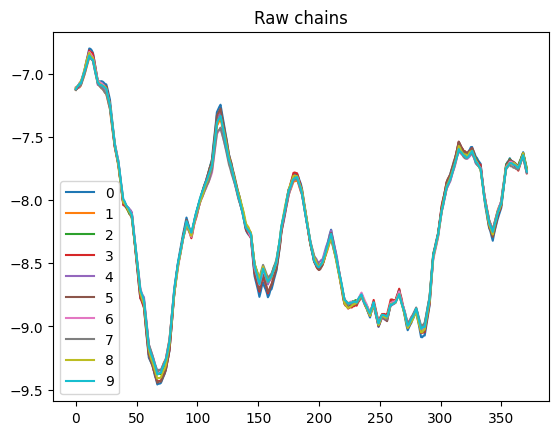

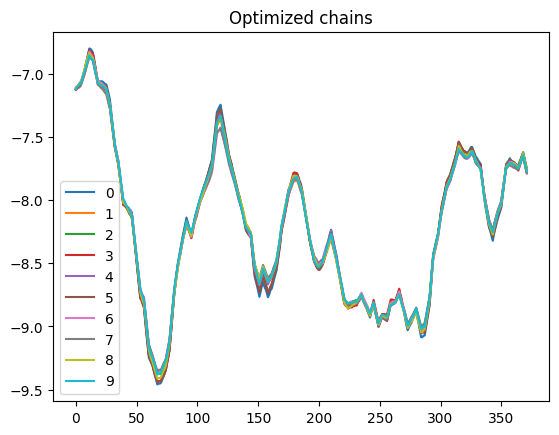

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.222  0.060   0.105    0.328      0.004    0.003     217.0     393.0   
eps    0.945  0.163   0.630    1.240      0.004    0.003    1781.0    2027.0   
p_out  0.117  0.056   0.022    0.221      0.001    0.000   10323.0   12196.0   

       r_hat  
sig     1.03  
eps     1.01  
p_out   1.00  


In [22]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

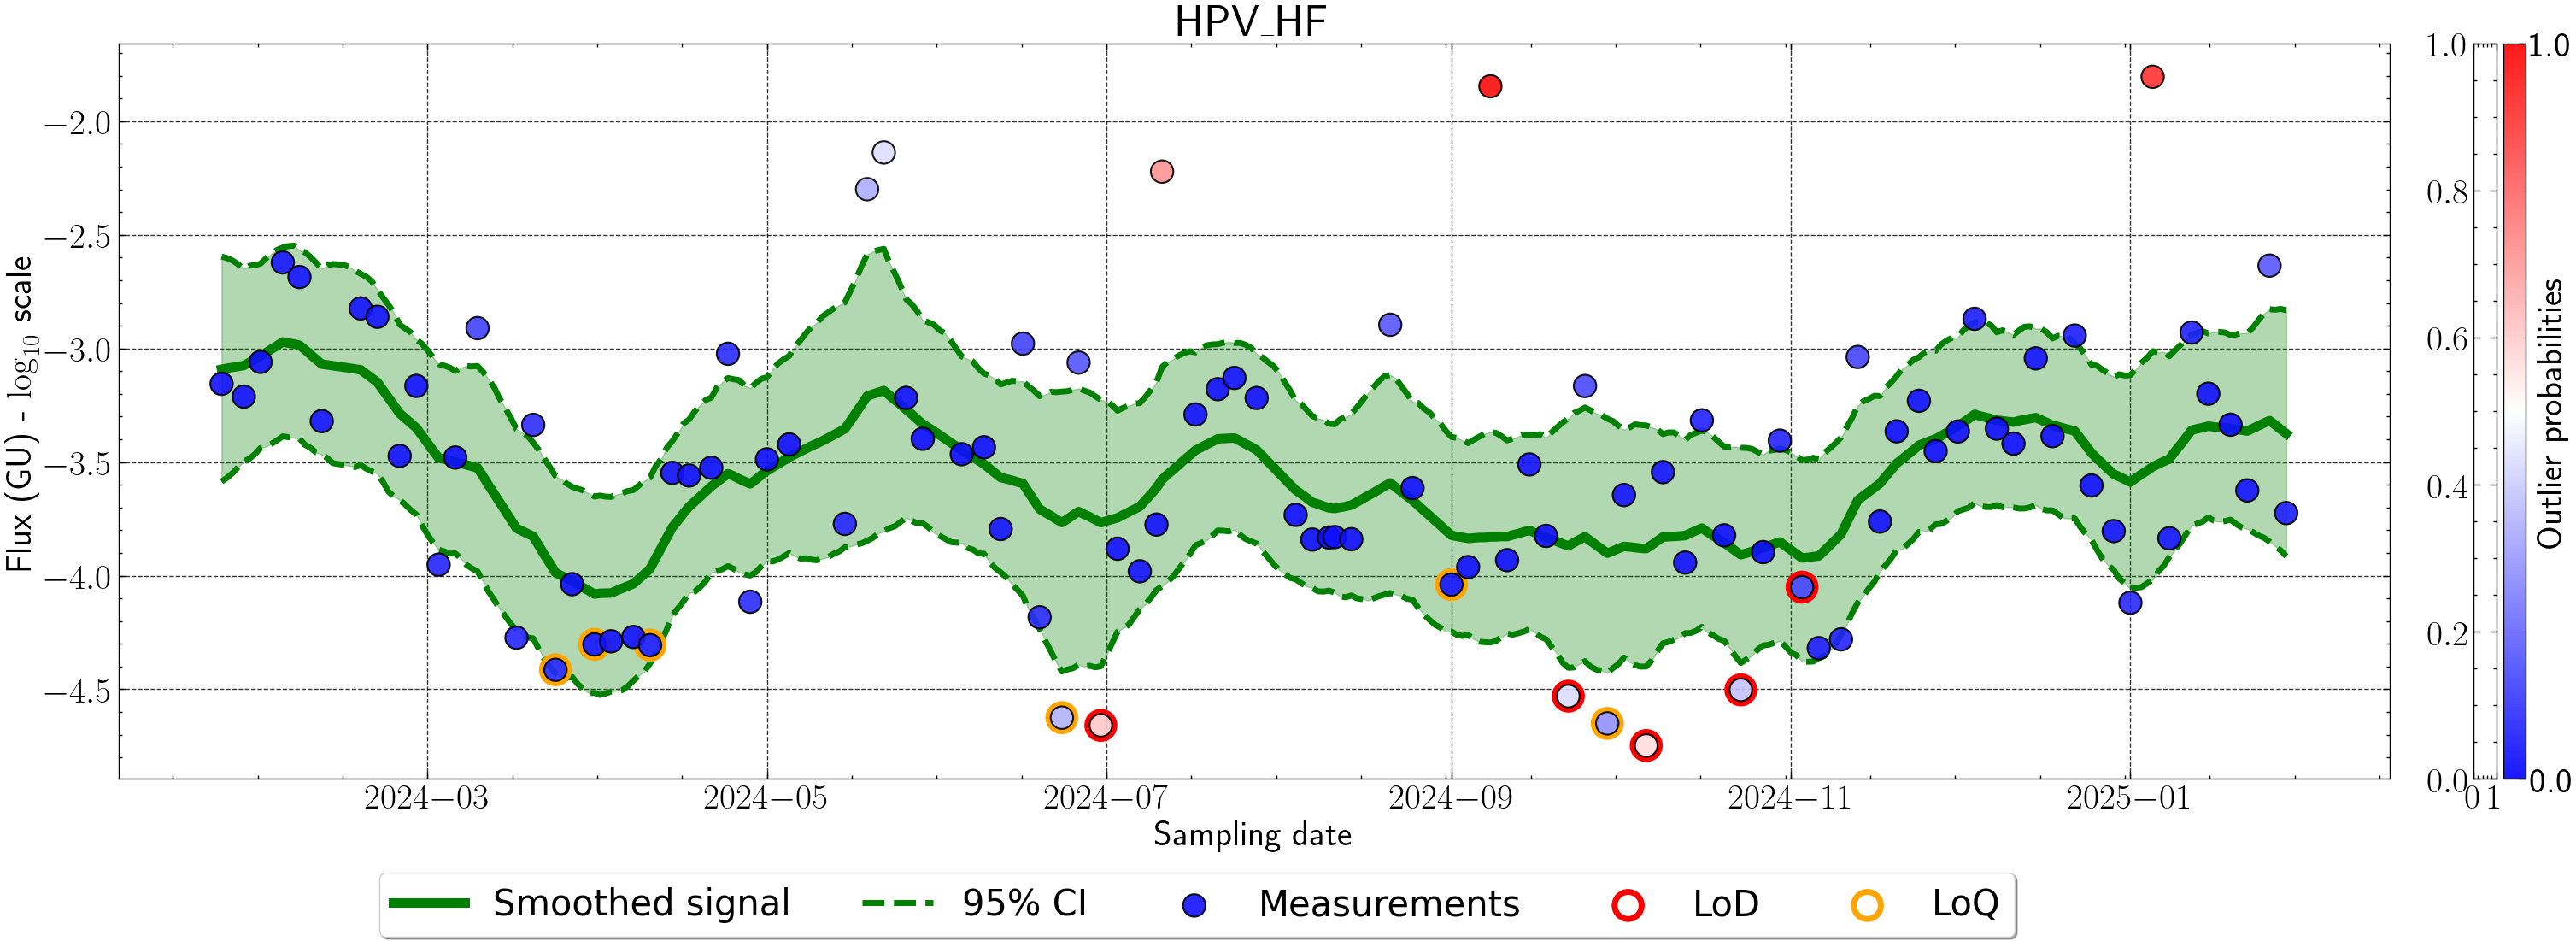

In [23]:
visualize_and_export(sub_data, 'obs_HPV_crAssphages', 'lod_HPV_crAssphages', 'loq_HPV_crAssphages','HPV_HF_2025-10-30_ratio_crAssphages')

In [24]:
# second, mtDNA:
observation_matrix = sub_data.obs_HPV_mtDNA.values
lod_matrix = sub_data.lod_HPV_mtDNA.values
loq_matrix = sub_data.loq_HPV_mtDNA.values

In [25]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 492 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.234  0.068   0.112    0.362      0.006    0.004      97.0     102.0   
eps    1.602  0.172   1.288    1.939      0.003    0.002    2449.0    8579.0   
p_out  0.072  0.046   0.002    0.156      0.000    0.000   17940.0   14598.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


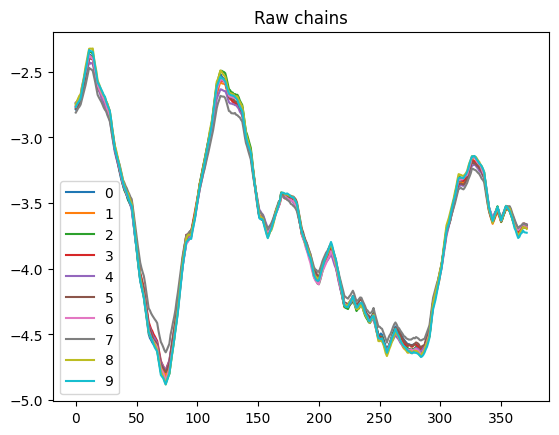

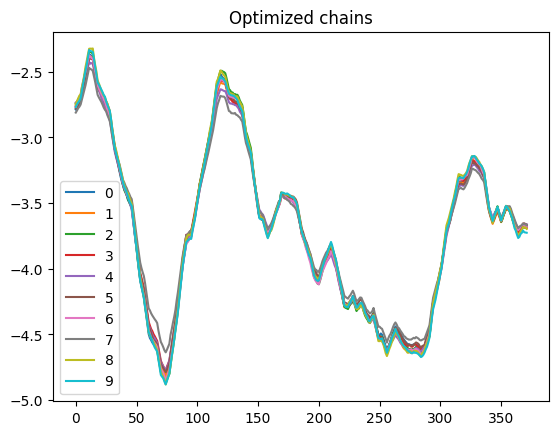

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.234  0.068   0.112    0.362      0.006    0.004      97.0     102.0   
eps    1.602  0.172   1.288    1.939      0.003    0.002    2449.0    8579.0   
p_out  0.072  0.046   0.002    0.156      0.000    0.000   17940.0   14598.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


In [26]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

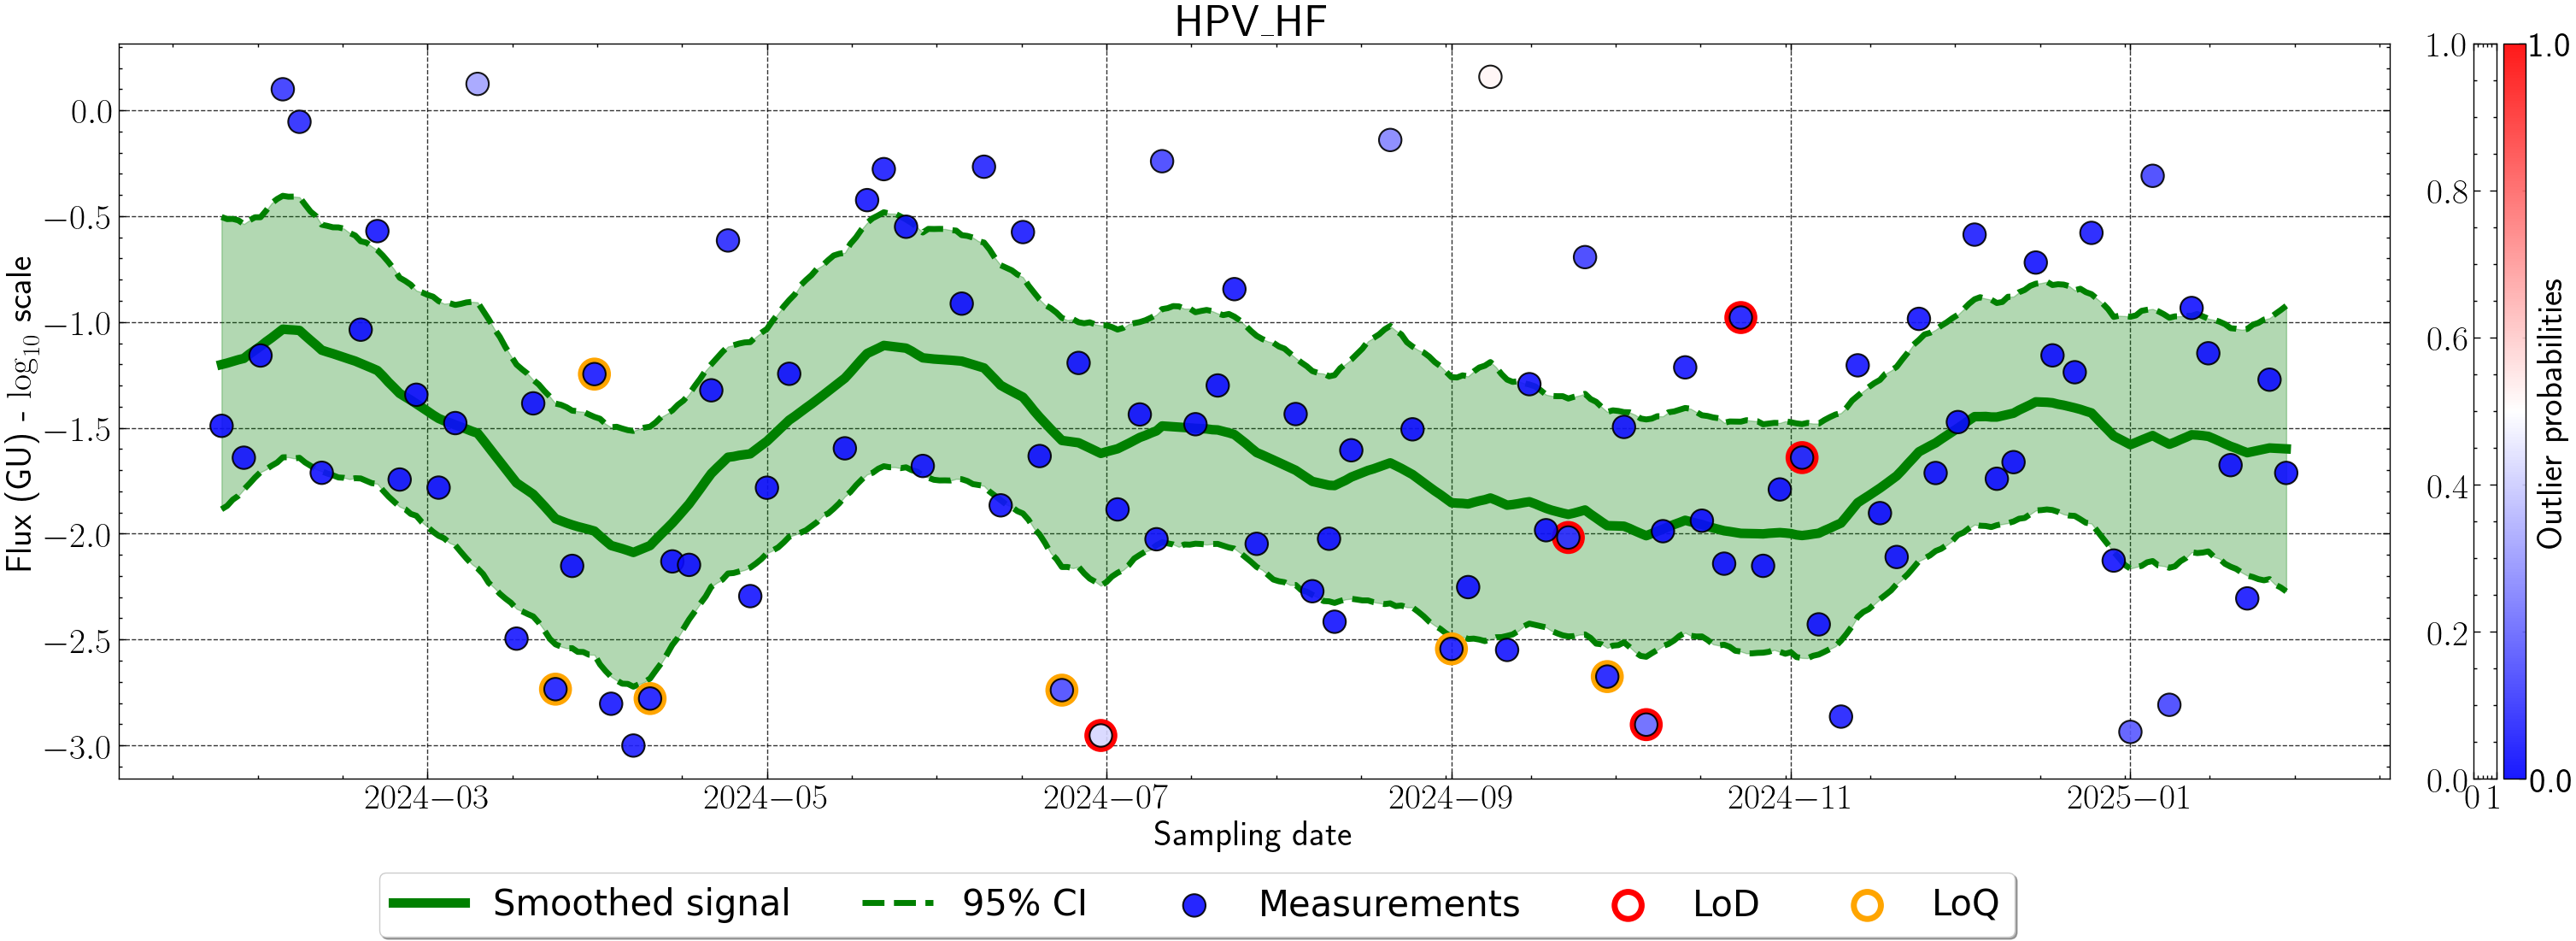

In [27]:
visualize_and_export(sub_data, 'obs_HPV_mtDNA', 'lod_HPV_mtDNA', 'loq_HPV_mtDNA','HPV_HF_2025-10-30_ratio_mtDNA')

In [28]:
# third, flux:

obs_col = 'obs_flux'
lod_col = 'lod_flux'
loq_col = 'loq_flux'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [29]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 383 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.201  0.055   0.106    0.300      0.003    0.002     246.0     500.0   
eps    0.973  0.138   0.713    1.236      0.003    0.002    2638.0    7775.0   
p_out  0.111  0.050   0.024    0.203      0.000    0.000   18357.0   16532.0   

       r_hat  
sig     1.02  
eps     1.00  
p_out   1.00  


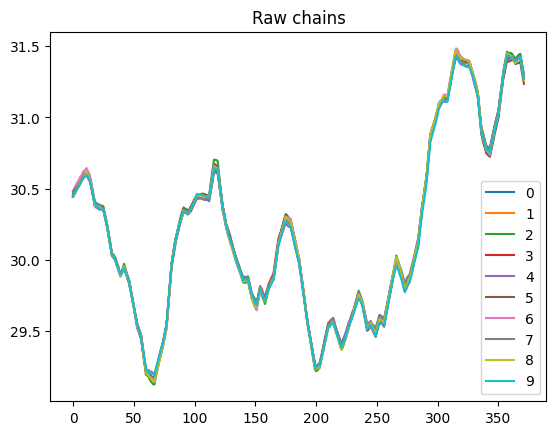

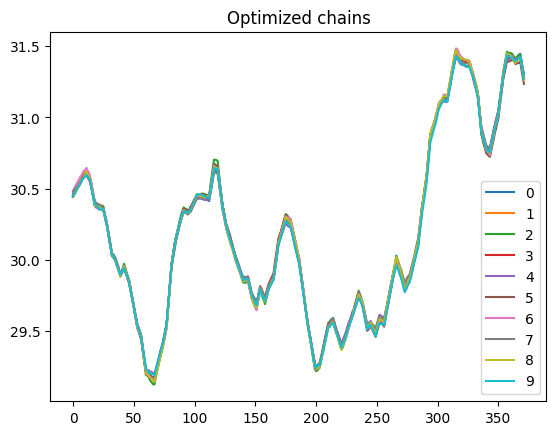

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.201  0.055   0.106    0.300      0.003    0.002     246.0     500.0   
eps    0.973  0.138   0.713    1.236      0.003    0.002    2638.0    7775.0   
p_out  0.111  0.050   0.024    0.203      0.000    0.000   18357.0   16532.0   

       r_hat  
sig     1.02  
eps     1.00  
p_out   1.00  


In [30]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

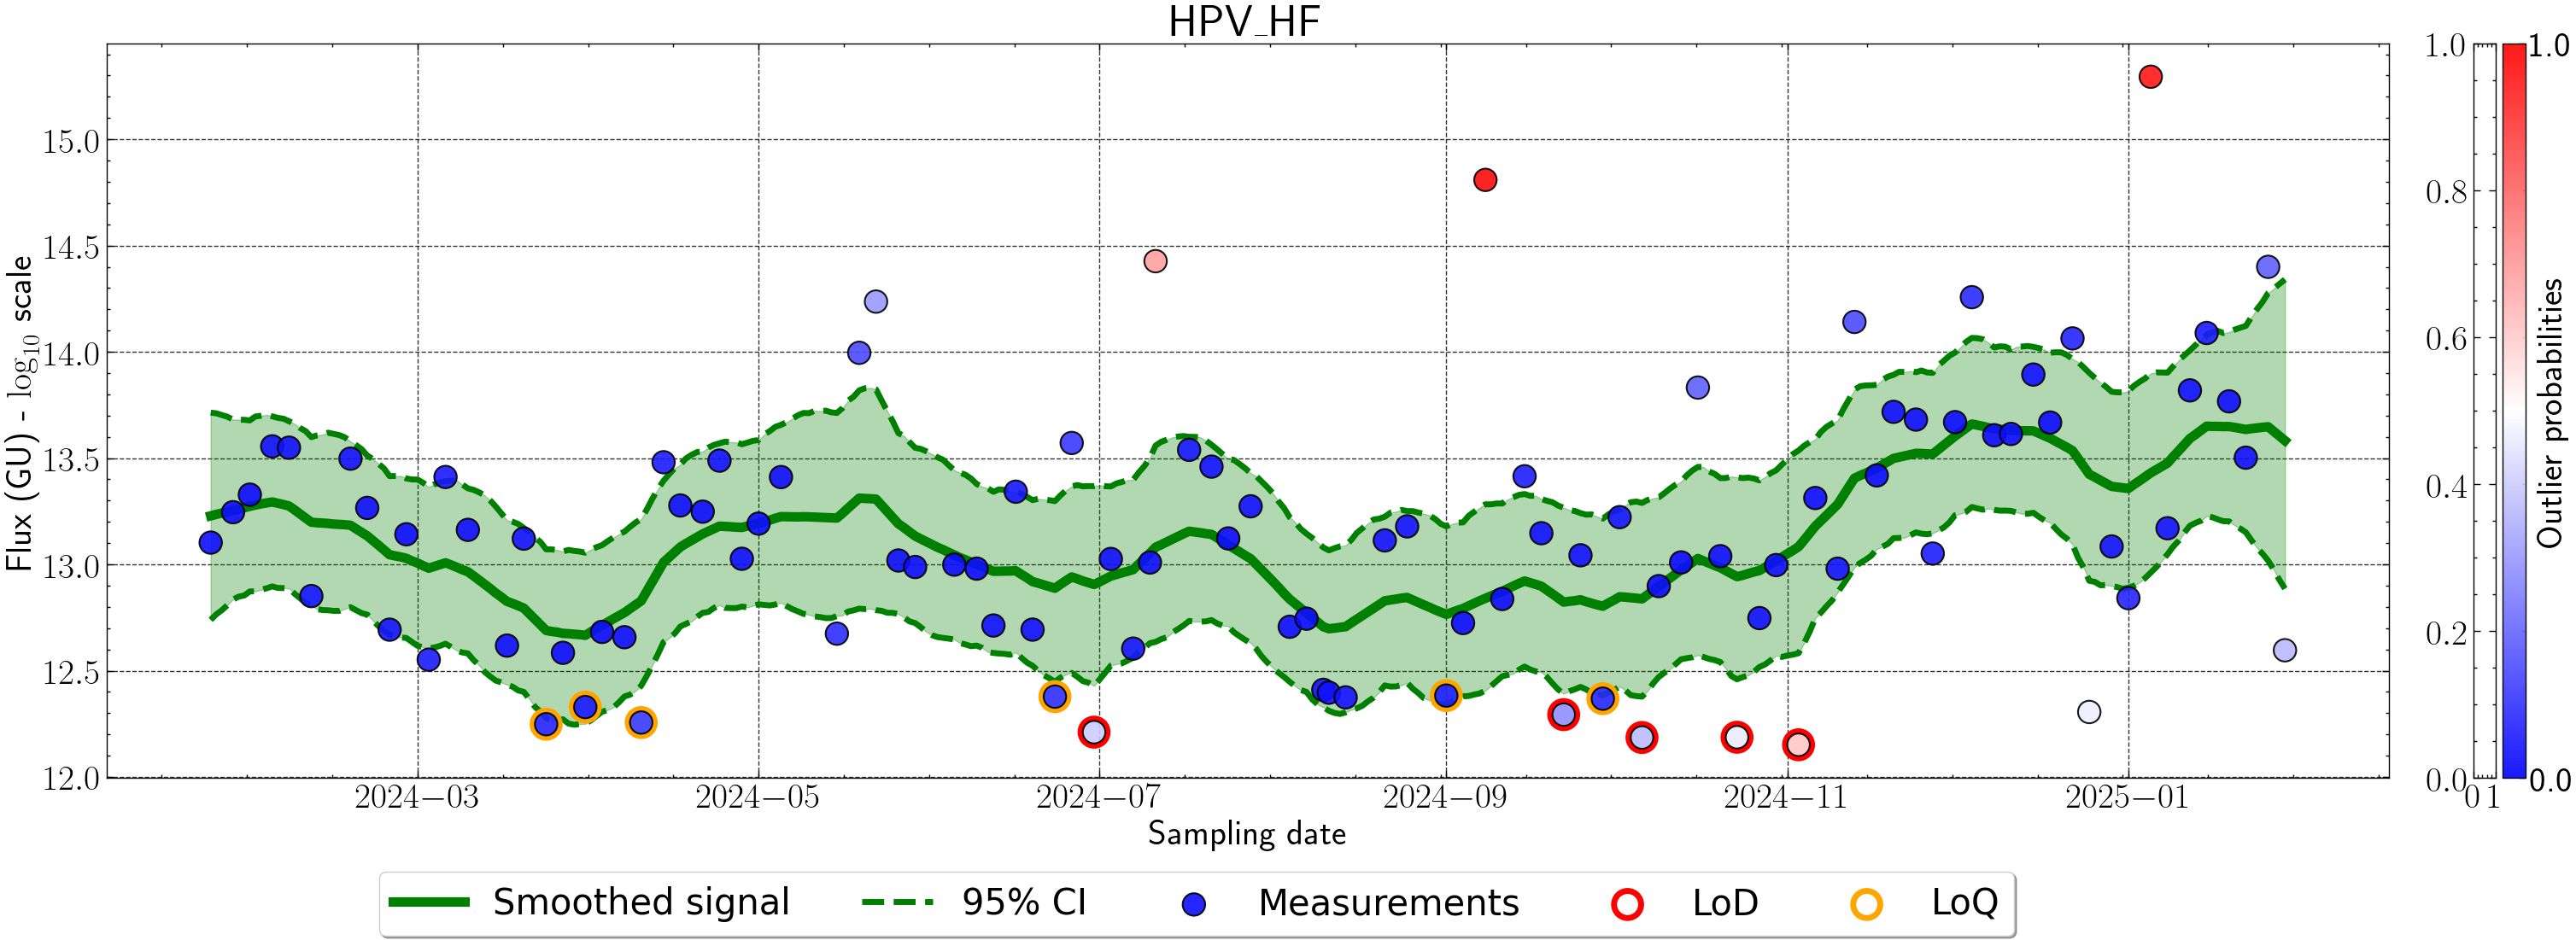

In [31]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col,'HPV_HF_2025-10-30_ratio_flux')

In [32]:
# last, conc:

obs_col = 'obs_HPV'
lod_col = 'lod_HPV'
loq_col = 'loq_HPV'

observation_matrix = sub_data[obs_col].values
lod_matrix = sub_data[lod_col].values
loq_matrix = sub_data[loq_col].values

In [33]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, loq_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 404 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.195  0.053   0.107    0.297      0.005    0.004     106.0     455.0   
eps    0.966  0.136   0.721    1.234      0.003    0.002    2842.0    6733.0   
p_out  0.109  0.051   0.015    0.198      0.000    0.000   18451.0   16311.0   

       r_hat  
sig     1.08  
eps     1.00  
p_out   1.00  


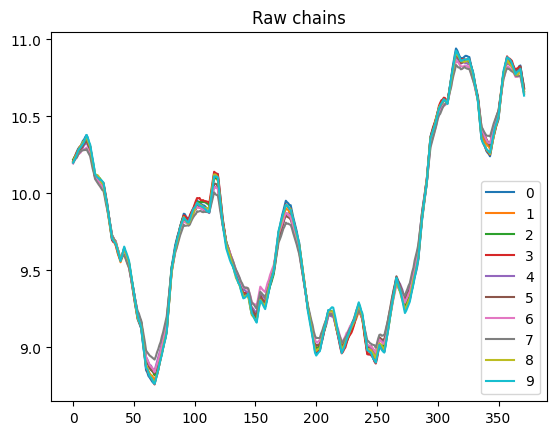

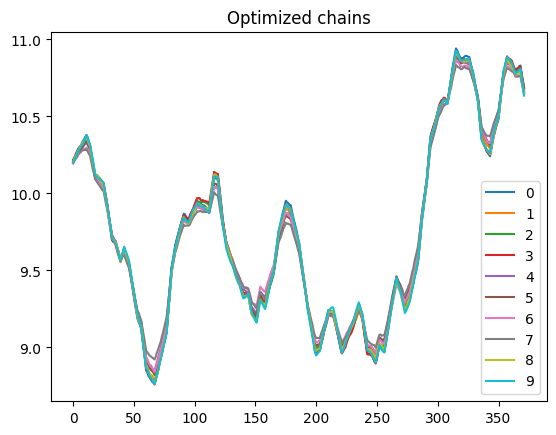

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.195  0.053   0.107    0.297      0.005    0.004     106.0     455.0   
eps    0.966  0.136   0.721    1.234      0.003    0.002    2842.0    6733.0   
p_out  0.109  0.051   0.015    0.198      0.000    0.000   18451.0   16311.0   

       r_hat  
sig     1.08  
eps     1.00  
p_out   1.00  


In [34]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

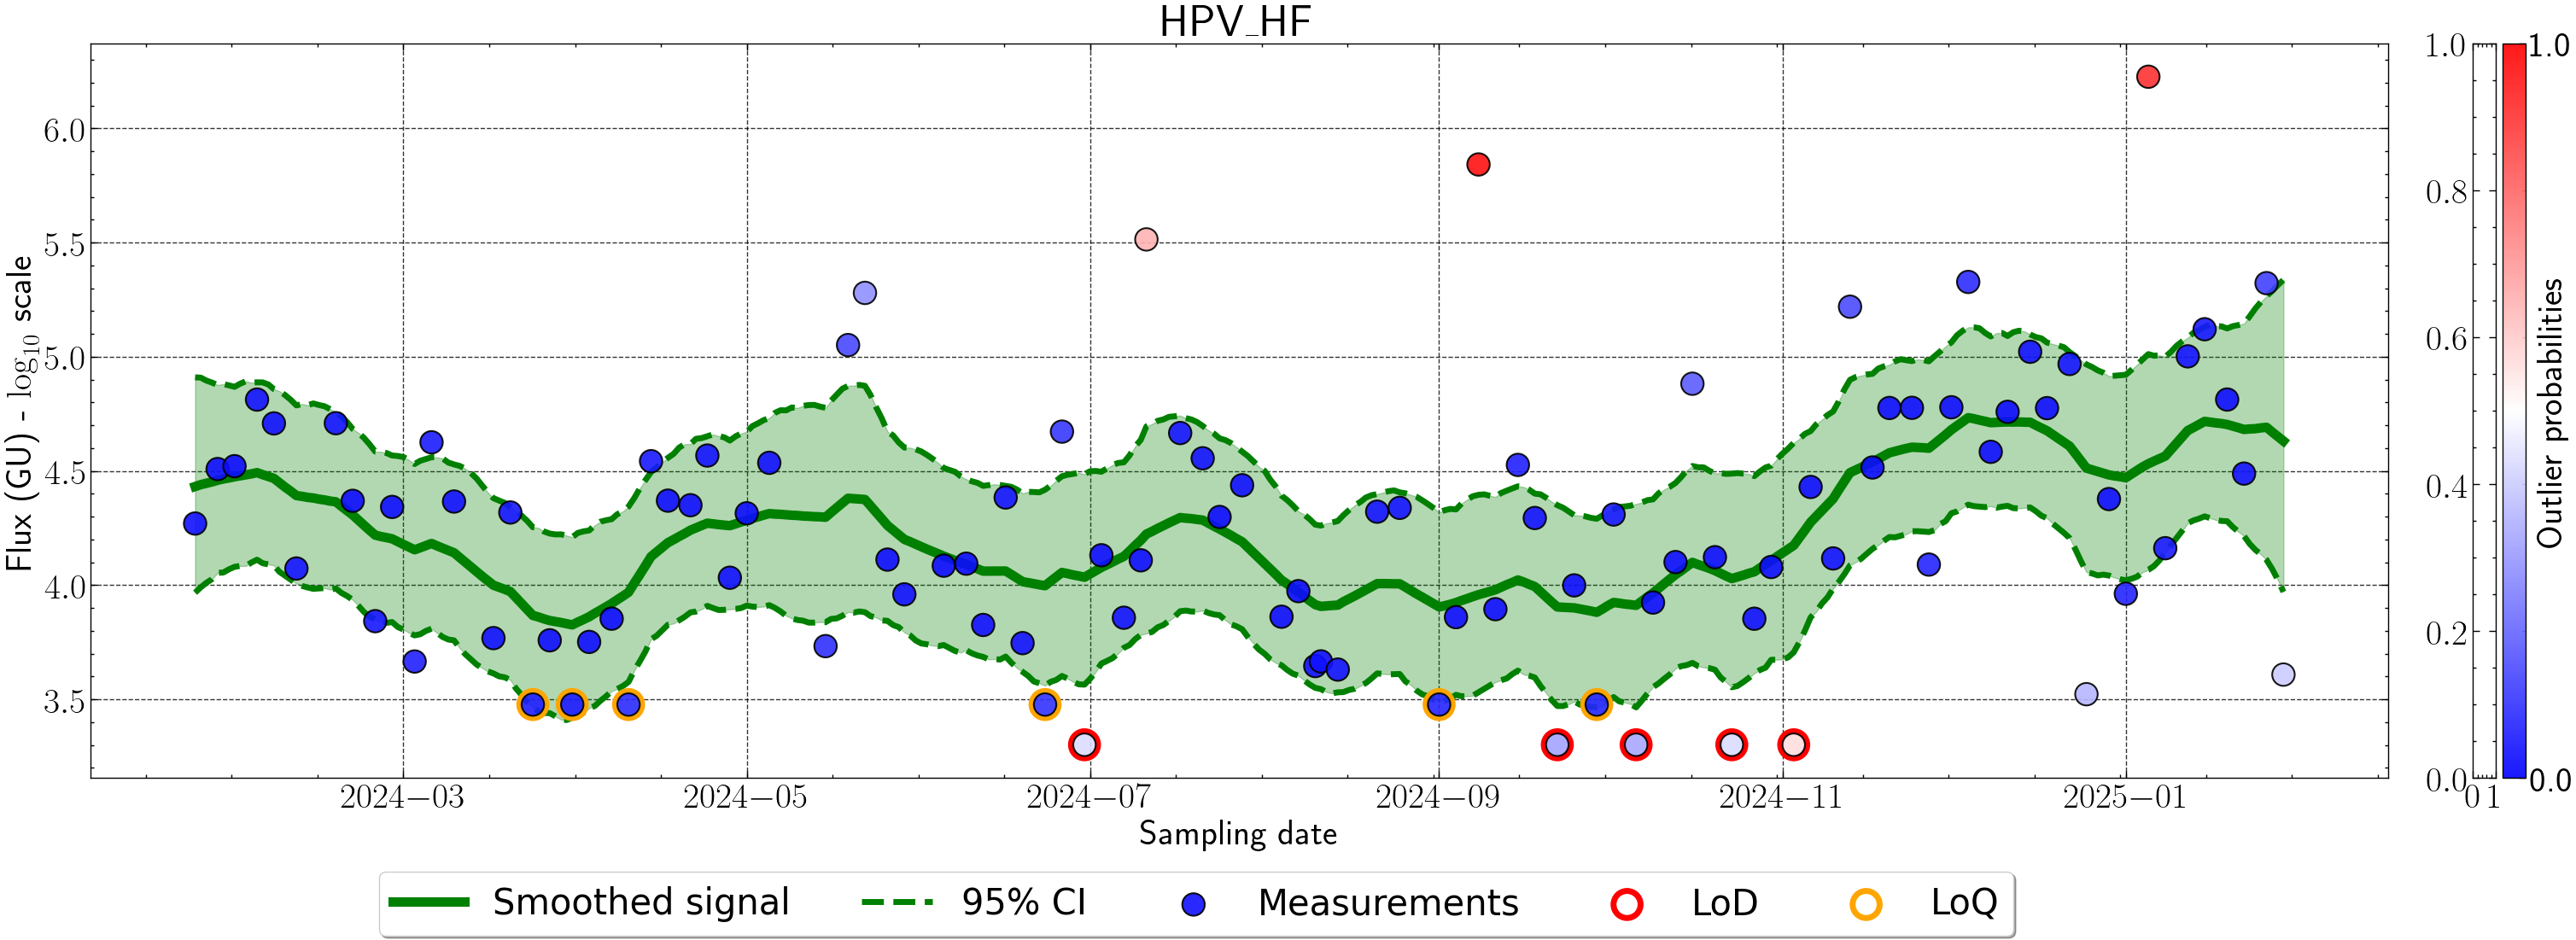

In [35]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col,'HPV_HF_2025-10-30_ratio_conc')

In [20]:
# last2, crAss standalone:

obs_col = 'obs_flux_crAssphages'
lod_col = 'lod_HPV'
loq_col = 'loq_HPV'

observation_matrix = sub_data[obs_col].values
lod_matrix = np.ones(sub_data.shape[0]) * -1000

In [21]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 185 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.158  0.034   0.100    0.224      0.002    0.001     343.0     845.0   
eps    0.397  0.075   0.262    0.542      0.002    0.001    2022.0    4747.0   
p_out  0.092  0.043   0.020    0.173      0.000    0.000   11898.0   14046.0   

       r_hat  
sig     1.03  
eps     1.01  
p_out   1.00  


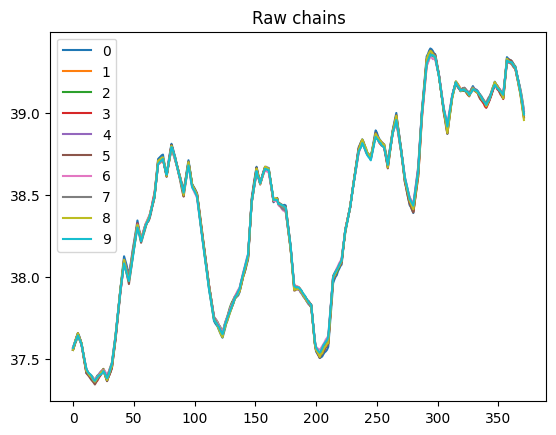

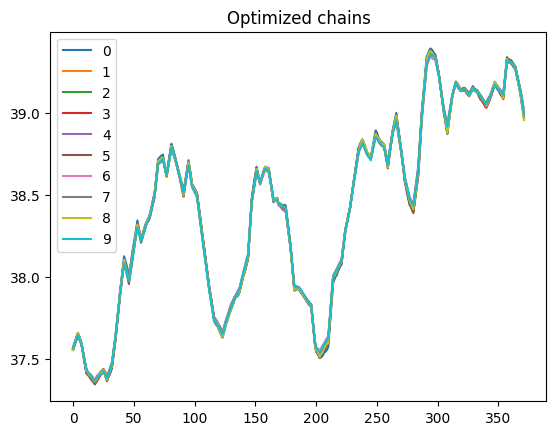

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.158  0.034   0.100    0.224      0.002    0.001     343.0     845.0   
eps    0.397  0.075   0.262    0.542      0.002    0.001    2022.0    4747.0   
p_out  0.092  0.043   0.020    0.173      0.000    0.000   11898.0   14046.0   

       r_hat  
sig     1.03  
eps     1.01  
p_out   1.00  


In [22]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

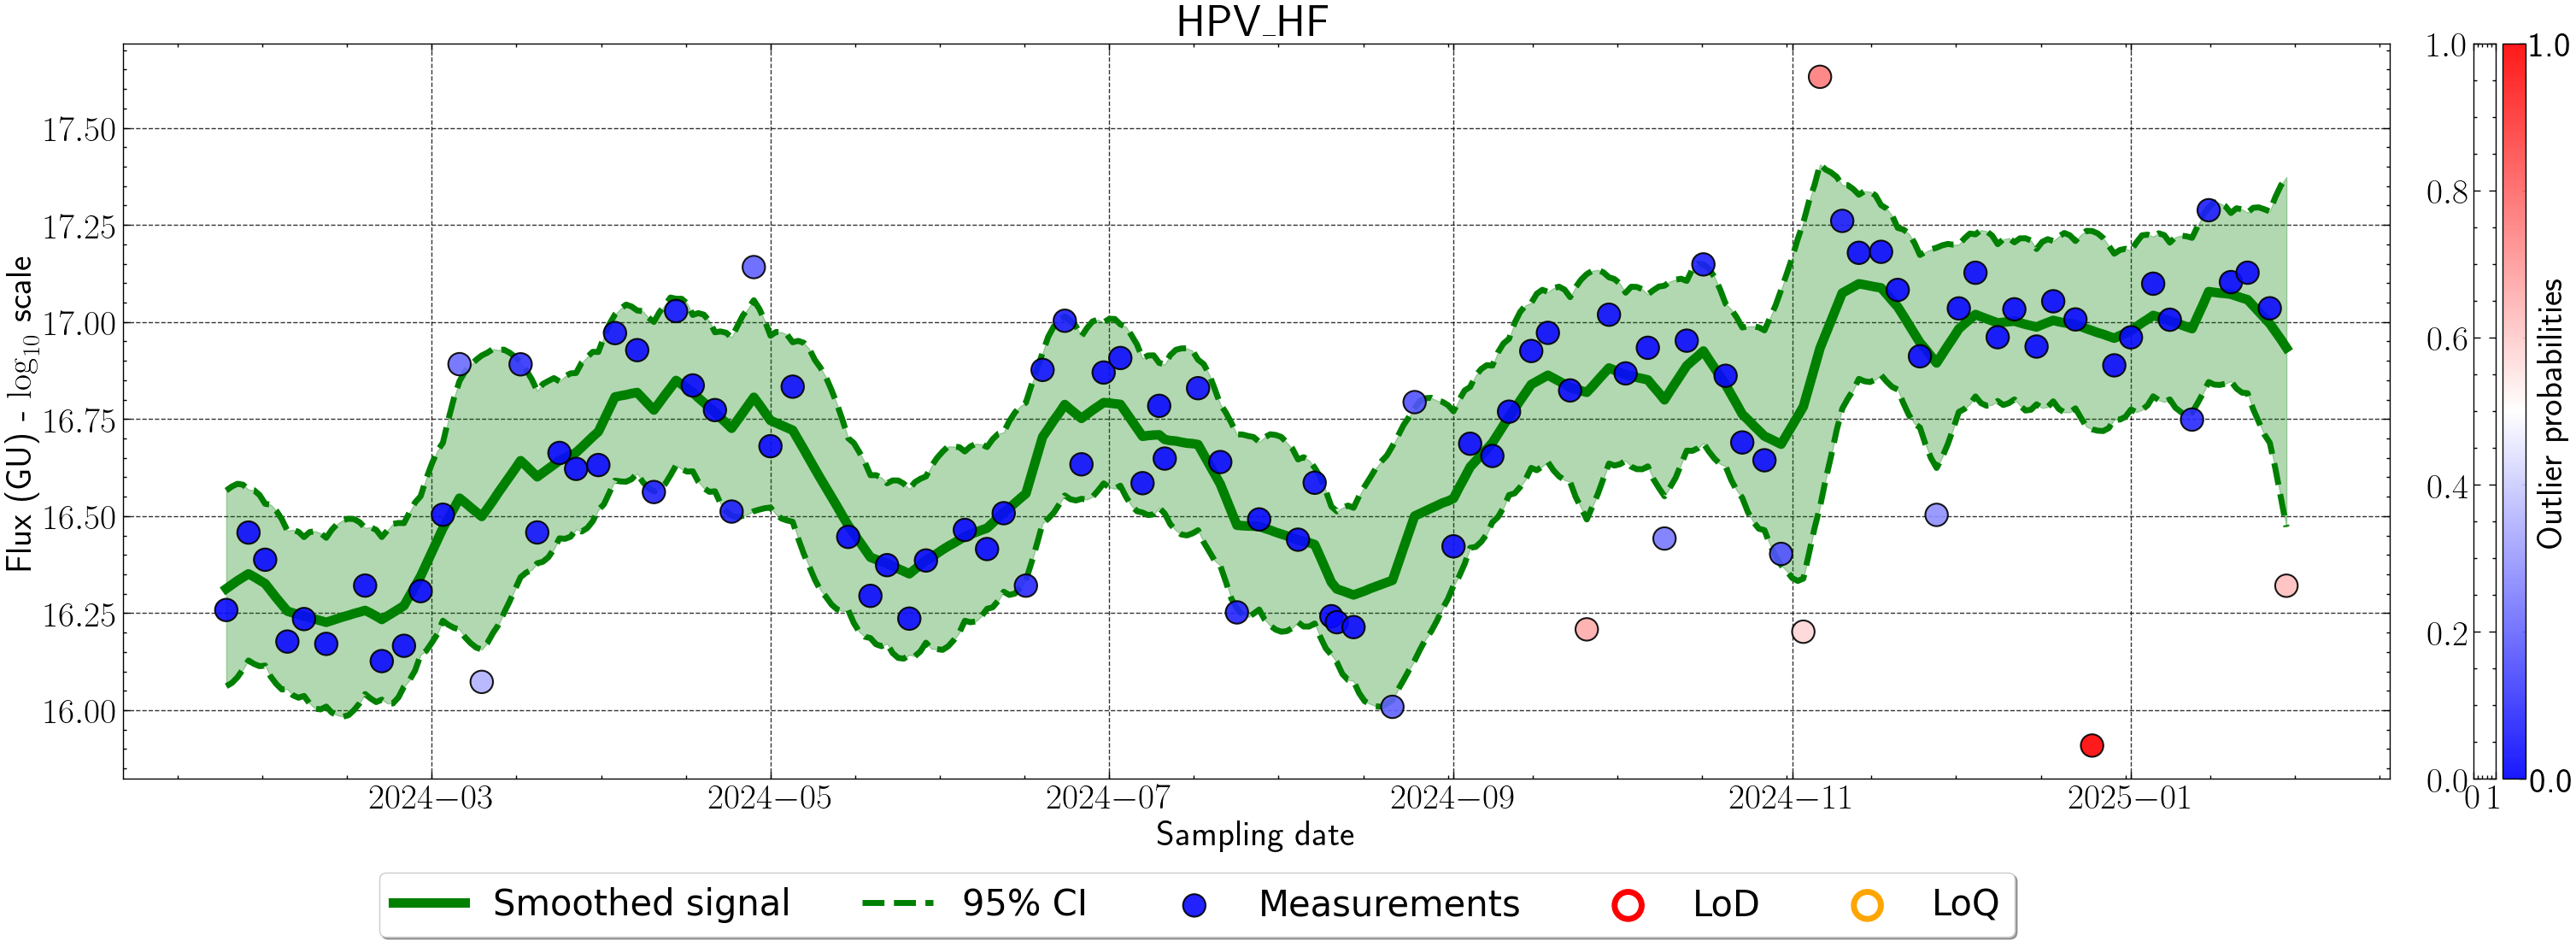

In [23]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col,'HPV_HF_2025-10-30_crAssphages_standalone')

In [24]:
sub_data.head()

,dateStart,obs_HPV,obs_mtDNA,obs_crAssphages,inhibition,plantVolume,lod_HPV,loq_HPV,obs_HPV_mtDNA,lod_HPV_mtDNA,...,loq_HPV_crAssphages,obs_flux,lod_flux,loq_flux,obs_flux_mtDNA,obs_flux_crAssphages,muX,ICL,ICU,pout
0,2024-01-24,9.831661,13.263841,17.097898,0.778384,680420000.0,7.600902,8.006368,-3.432179,-5.662938,...,-9.091531,30.169882,27.939123,28.344588,33.602061,37.436119,37.562683,36.984498,38.144596,0.023288
1,2024-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37.585956,37.003371,38.168363,NaN
2,2024-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37.609504,37.036918,38.184409,NaN
3,2024-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37.630260,37.084119,38.179240,NaN
4,2024-01-28,10.381030,14.159901,17.776978,0.515037,546090000.0,7.600902,8.006368,-3.778871,-6.558999,...,-9.770610,30.499325,27.719197,28.124662,34.278196,37.895272,37.650621,37.136619,38.150100,0.024575


In [25]:
# last2, mtDNA standalone:

obs_col = 'obs_flux_mtDNA'
lod_col = 'lod_HPV'
loq_col = 'loq_HPV'

observation_matrix = sub_data[obs_col].values
lod_matrix = np.ones(sub_data.shape[0]) * -1000

In [26]:
nb_chains = 10
tuning_iters = 4000
sampling_iters = 2000

scou = SCOU_RW_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()

# Done
notify_mac("Jupyter", "Work done !")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 10 chains for 4_000 tune and 2_000 draw iterations (40_000 + 20_000 draws total) took 338 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.201  0.053   0.107    0.302      0.003    0.002     244.0     355.0   
eps    1.093  0.142   0.830    1.355      0.003    0.002    2682.0   10410.0   
p_out  0.095  0.045   0.020    0.180      0.000    0.000   17860.0   14846.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


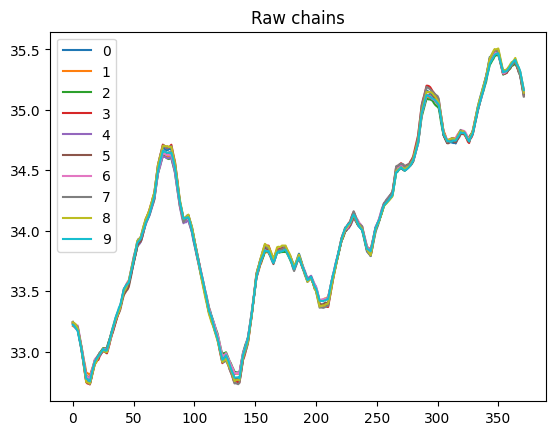

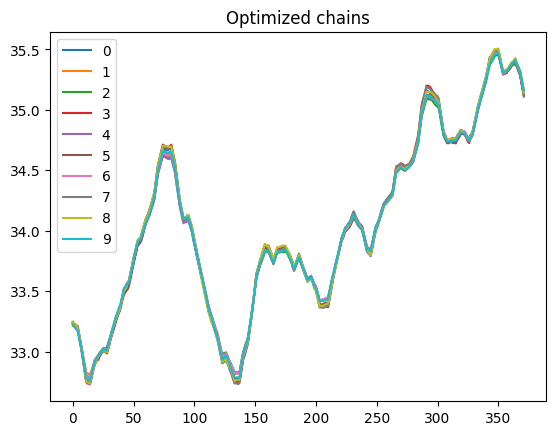

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.201  0.053   0.107    0.302      0.003    0.002     244.0     355.0   
eps    1.093  0.142   0.830    1.355      0.003    0.002    2682.0   10410.0   
p_out  0.095  0.045   0.020    0.180      0.000    0.000   17860.0   14846.0   

       r_hat  
sig     1.03  
eps     1.00  
p_out   1.00  


In [27]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


scou.visualize_latents(selected_chains)
scou.predict(selected_chains)

sub_data['muX'] = scou.muX
sub_data['ICL'] = scou.CIL
sub_data['ICU'] = scou.CIU
sub_data['pout'] = scou.pointwise_pout

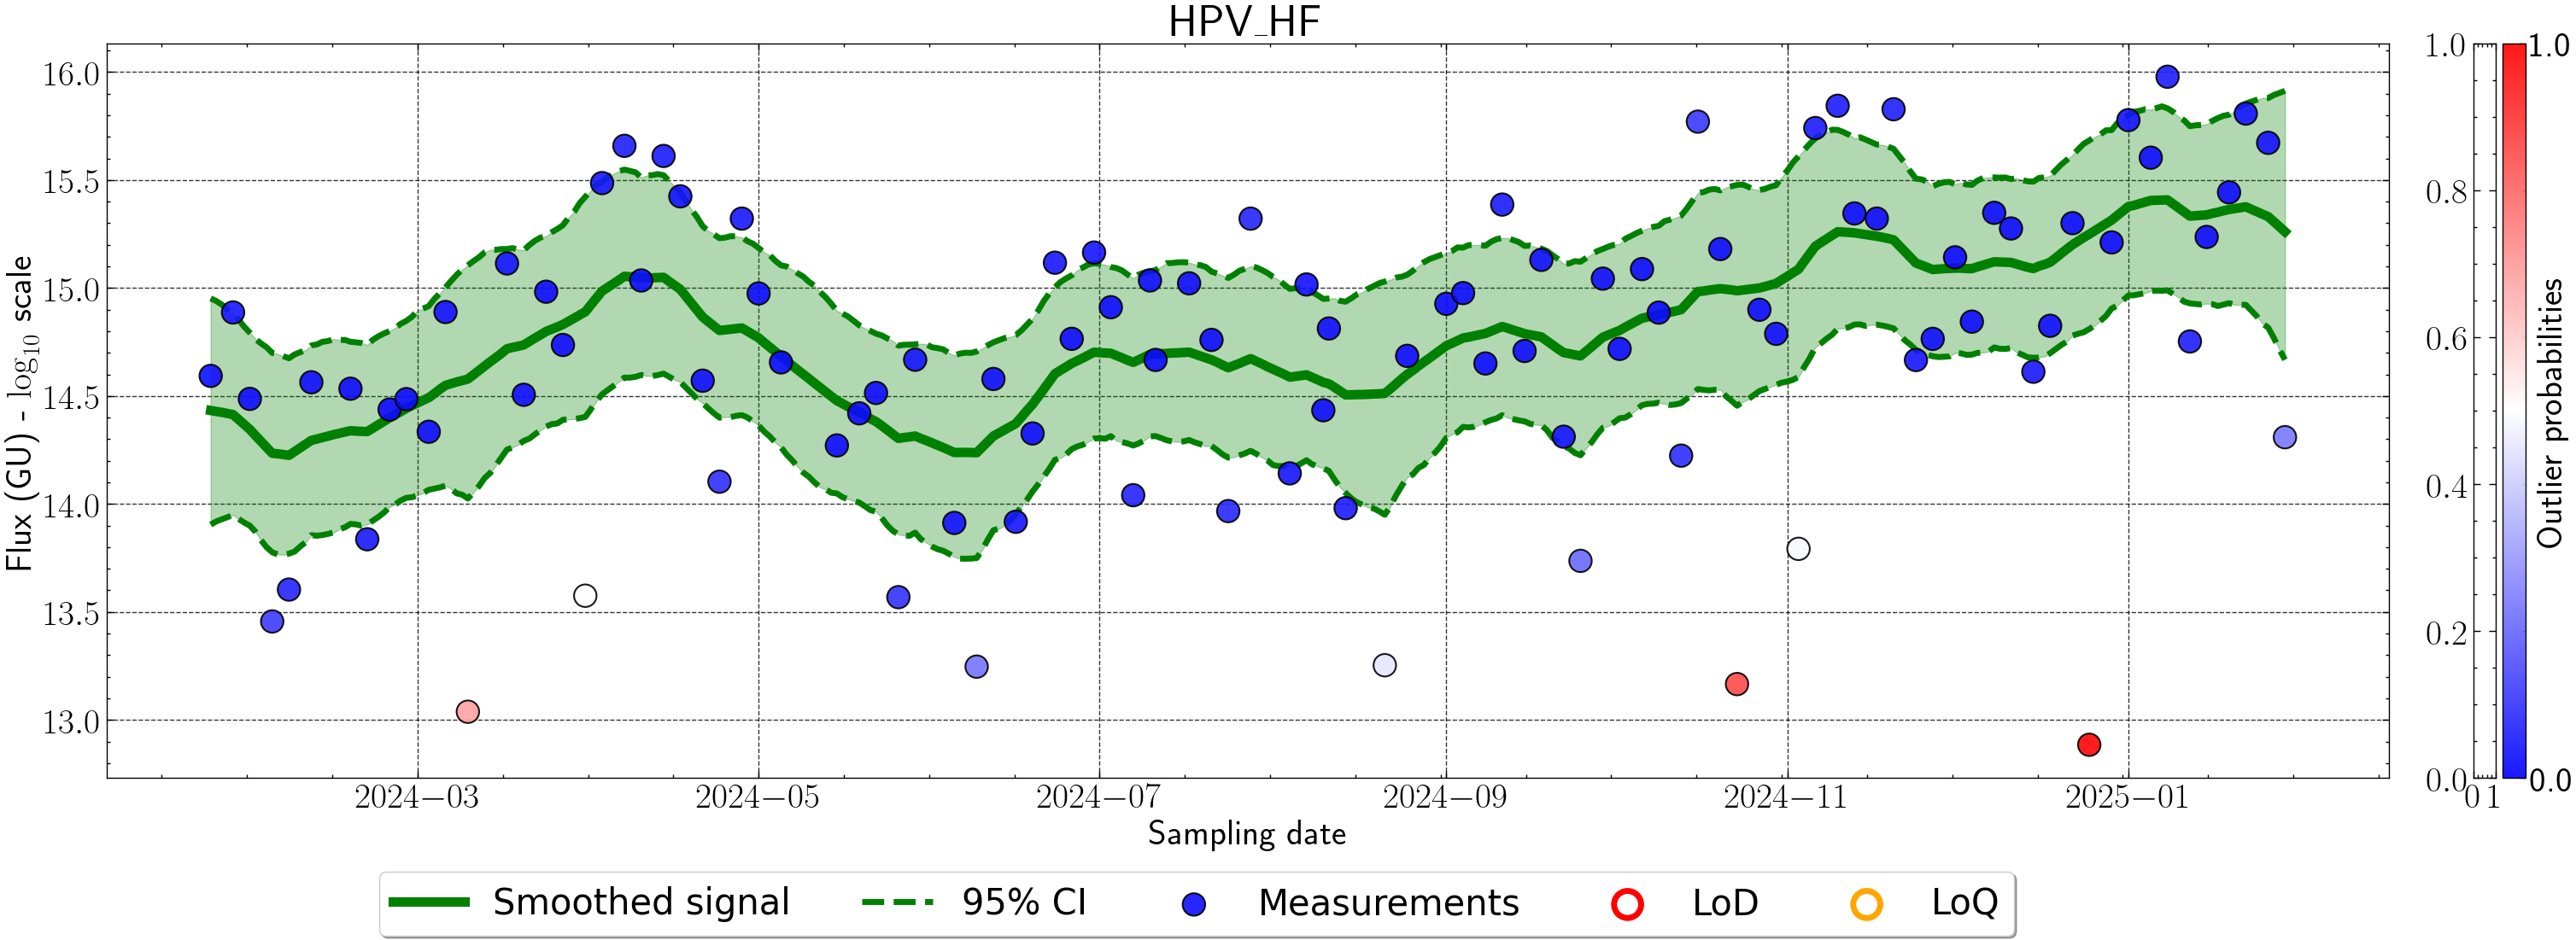

In [28]:
visualize_and_export(sub_data, obs_col, lod_col, loq_col,'HPV_HF_2025-10-30_mtDNA_standalone')